In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import xgboost as xgb

from matplotlib import gridspec 
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RANSACRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor


In [8]:
def metricas_validacion_cruzada(modelo, modelo_nombre,k, X, y ):
    MAE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_mean_absolute_error')
    r2 = cross_val_score(modelo, X, y, cv=k, scoring = 'r2')
    MSE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_mean_squared_error')
    RMSE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_root_mean_squared_error')


    return pd.DataFrame({'Modelo': modelo_nombre,
                    'MAE' : str(round(np.mean(-MAE),5))+'+/-'+str(round(np.std(-MAE),2)),
                  'MSE' : str(round(np.mean(-MSE),5))+'+/-'+str(round(np.std(-MSE),2)),
                  'RMSE' : str(round(np.mean(-RMSE),5))+'+/-'+str(round(np.std(-RMSE),2)),
                'R2' : str(round(np.mean(r2),5))+'+/-'+str(round(np.std(-r2),2))
    }, index = [0])


In [9]:
def metricas(modelo, yobs, yhat):
    # MAE 
    MAE = np.mean(np.abs(yobs-yhat))
    # MAPE
    MAPE = 100*np.mean(np.abs((yobs-yhat)/yobs))
    # RMSE
    RMSE = np.sqrt(np.mean((yobs-yhat)**2))
    # MSE
    MSE = np.mean((yobs-yhat)**2)
    # R2
    R2 = r2_score(yobs, yhat) 
    
    return pd.DataFrame({'Modelo' : modelo,
                         'MAE' : MAE,
                         'MAPE' : MAPE, 
                         'RMSE' : RMSE,
                         'MSE' : MSE, 
                         'R2': R2
    }, index =[0])

In [10]:
def validacion_cruzada(modelo,X,y, k_folds):
    metrica = pd.DataFrame()
    for i in range(k_folds):
        X_train_vc = X.drop(X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds)].index)
        y_train_vs = y.drop(y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)].index)
        X_test_vc = X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds)]
        y_test_vs = y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)]
        ajuste = LinearRegression().fit(X_train_vc,y_train_vs)
        y_ajustados = ajuste.predict(X_test_vc)
        metrica = metrica.append(metricas('Doblez '+ str(i), y_test_vs ,y_ajustados))
        
        salida = pd.DataFrame({'MAE': str(round(metrica['MAE'].mean(),2))+'+/-'+str(round(np.std(metrica['MAE']),2)),
                               'MAPE': str(round(metrica['MAPE'].mean(),2))+'+/-'+str(round(np.std(metrica['MAPE']),2)),
                               'RMSE': str(round(metrica['RMSE'].mean(),2))+'+/-'+str(round(np.std(metrica['RMSE']),2)),
                               'MSE':   str(round(metrica['MSE'].mean(),2))+'+/-'+str(round(np.std(metrica['MSE']),2)),
                               'R2':    str(round(metrica['R2'].mean(),2))+'+/-'+str(round(np.std(metrica['R2']),2))
                              }, index = [0])
    return salida

In [11]:
data = pd.read_csv('Carlosdata.csv')

In [12]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [13]:
data['date'] = pd.to_datetime(data['date'], format ='%Y-%m-%d')
data['yr_built'] = pd.to_datetime(data['yr_built'], format = '%Y').dt.year
data.loc[data['yr_renovated']!= 0, 'yr_renovated' ] = pd.to_datetime(data.loc[data['yr_renovated']!= 0, 'yr_renovated' ], format = '%Y').dt.year

In [14]:
data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [15]:
data = data[data['price']<2000000]

data = data[(data['bedrooms']<6)&
     (data['sqft_living']<7000)&
     (data['sqft_above']<5000)&
     (data['sqft_basement']<3000)&
     (data['sqft_lot15']<20000)]

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [17]:
data['month'] = data['date'].dt.month
data['week_of_year'] = data['date'].dt.weekofyear
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek


C:\Users\carlo\AppData\Local\Temp\ipykernel_12672\3071502936.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week_of_year'] = data['date'].dt.weekofyear


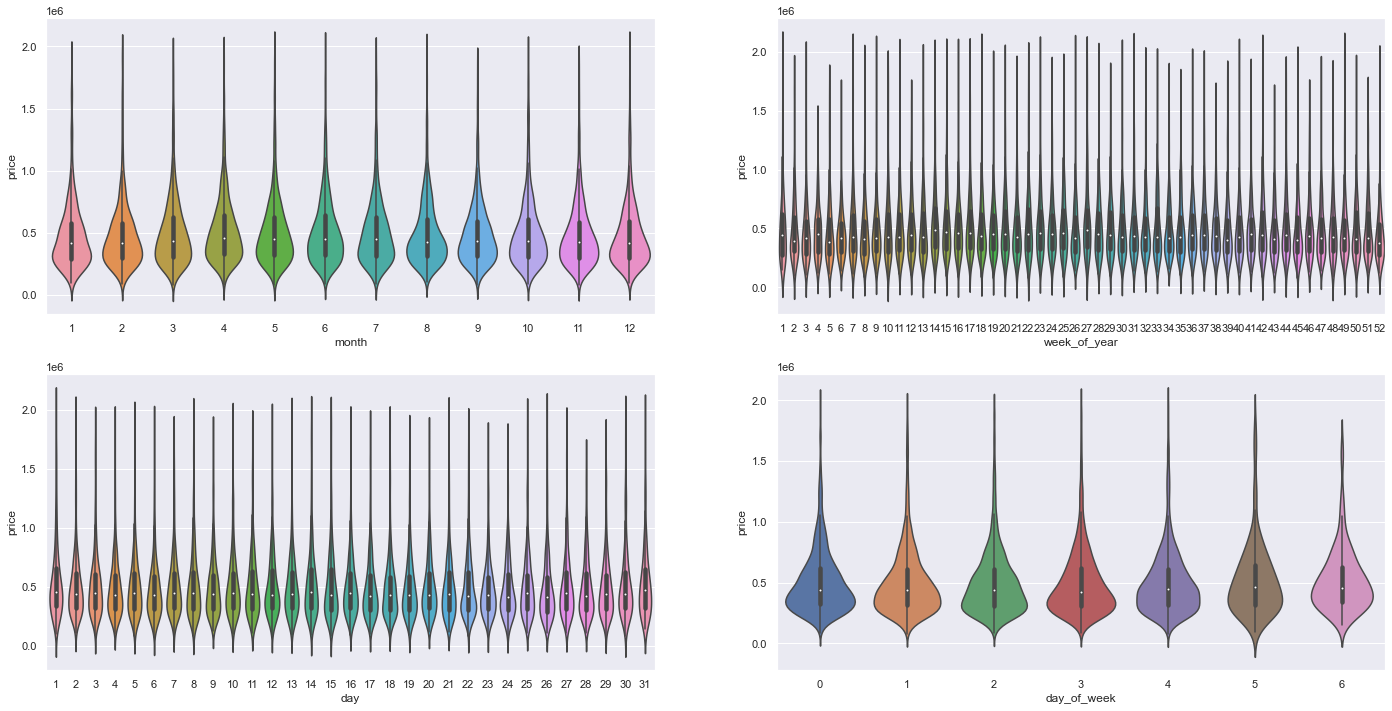

In [18]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(2, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.violinplot(x = 'month', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.violinplot(x = 'week_of_year', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.violinplot(x = 'day', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.violinplot(x = 'day_of_week', y='price', data = data)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

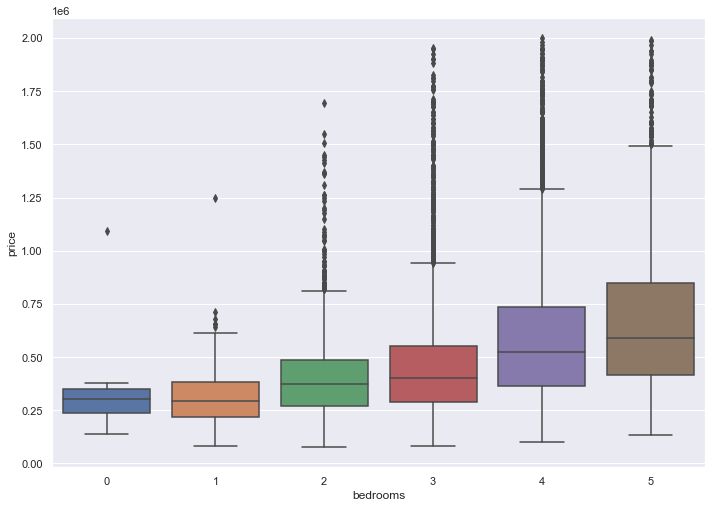

In [19]:
sns.boxplot(x='bedrooms', y='price', data = data)

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

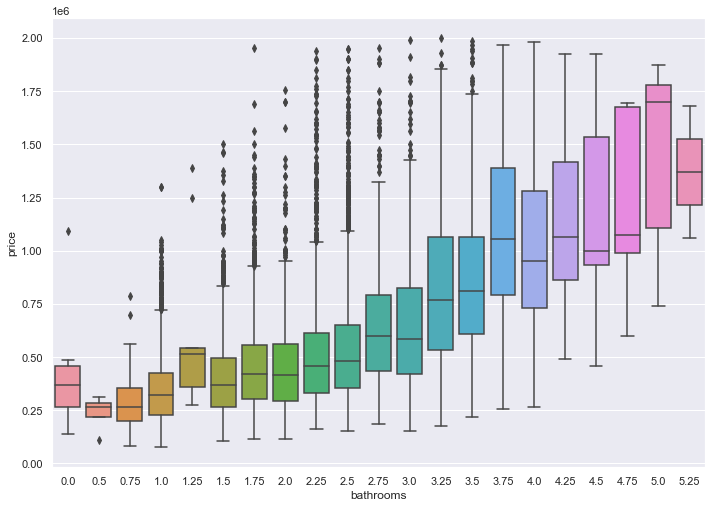

In [20]:
sns.boxplot(x='bathrooms', y='price', data = data)

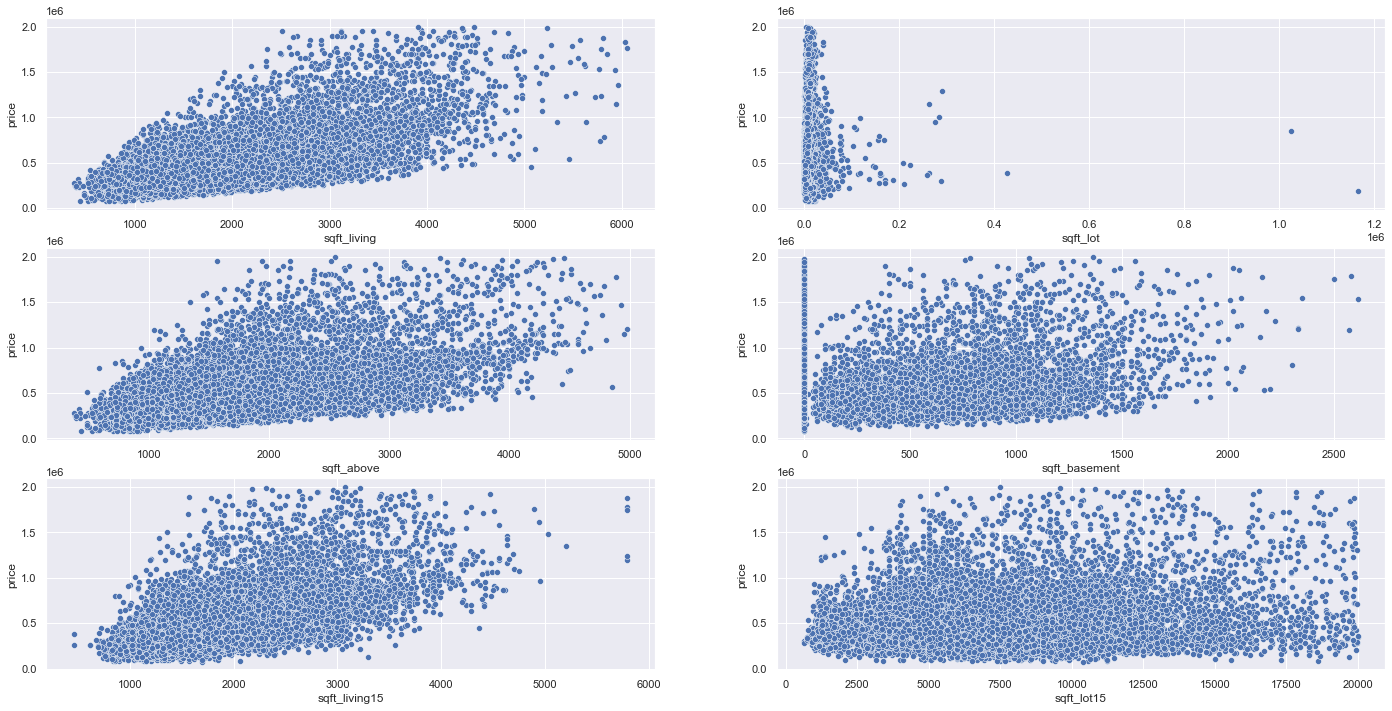

In [22]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(3, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.scatterplot(x = 'sqft_living', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.scatterplot(x = 'sqft_lot', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.scatterplot(x = 'sqft_above', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.scatterplot(x = 'sqft_basement', y='price', data = data)
ax5 = fig.add_subplot(gs[2,0])
ax5 = sns.scatterplot(x = 'sqft_living15', y='price', data = data)
ax6 = fig.add_subplot(gs[2,1])
ax6 = sns.scatterplot(x = 'sqft_lot15', y='price', data = data)

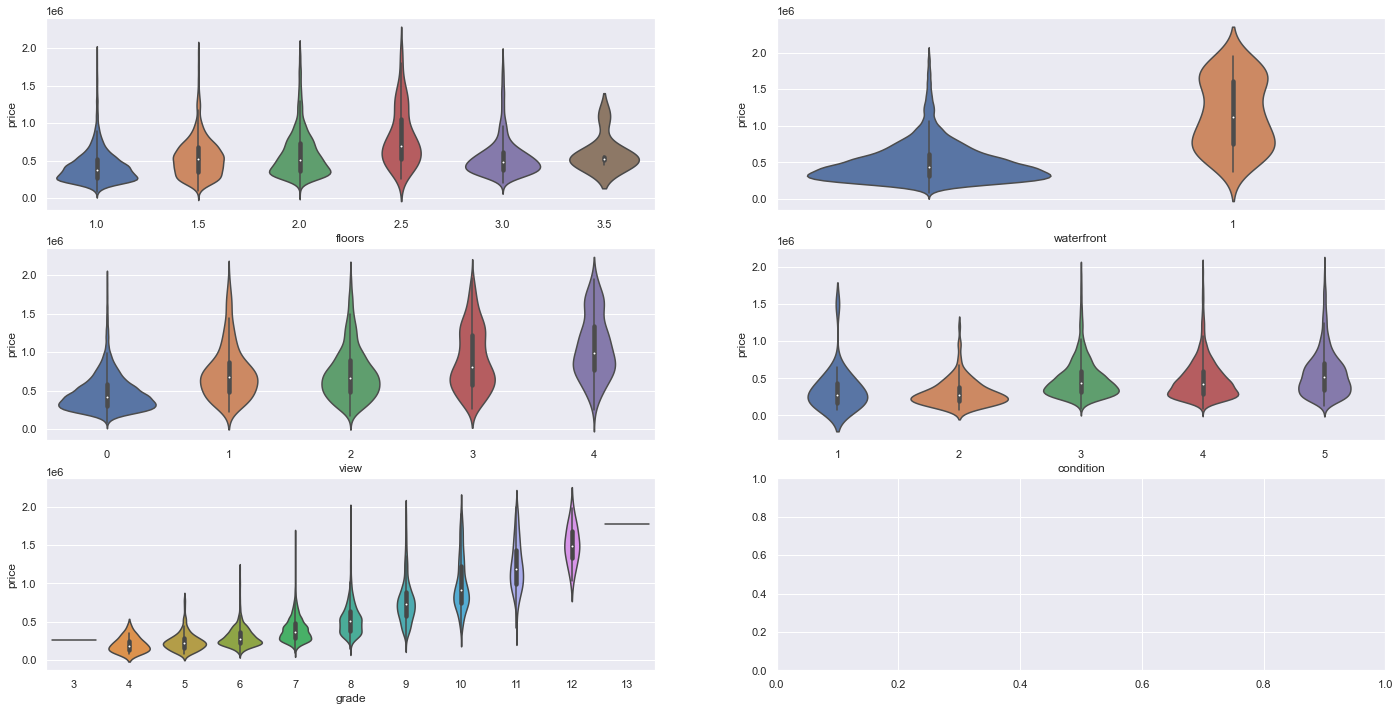

In [23]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(3, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.violinplot(x = 'floors', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.violinplot(x = 'waterfront', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.violinplot(x = 'view', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.violinplot(x = 'condition', y='price', data = data)
ax5 = fig.add_subplot(gs[2,0])
ax5 = sns.violinplot(x = 'grade', y='price', data = data)
ax6 = fig.add_subplot(gs[2,1])
# ax6 = sns.scatterplot(x = 'sqft_lot15', y='price', data = data)

In [24]:
data['yr_renovated_dummy'] = data['yr_renovated'].apply(lambda x: 1 if x!=0 else 0)

In [25]:
columns = ['price','bedrooms', 'bathrooms', 'sqft_living','waterfront', 'view', 'condition', 'grade',
          'yr_built', 'yr_renovated_dummy','lat','long']
data_aux = data[columns]

In [26]:
data_aux['property_age'] = 2015-data_aux['yr_built']

C:\Users\carlo\AppData\Local\Temp\ipykernel_12672\2804049904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aux['property_age'] = 2015-data_aux['yr_built']


In [27]:
data_aux.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,view,condition,grade,yr_built,yr_renovated_dummy,lat,long,property_age
0,221900.0,3,1.00,1180,0,0,3,7,1955,0,47.5112,-122.257,60
1,538000.0,3,2.25,2570,0,0,3,7,1951,1,47.7210,-122.319,64
2,180000.0,2,1.00,770,0,0,3,6,1933,0,47.7379,-122.233,82
3,604000.0,4,3.00,1960,0,0,5,7,1965,0,47.5208,-122.393,50
4,510000.0,3,2.00,1680,0,0,3,8,1987,0,47.6168,-122.045,28
